In [16]:
import graphviz
from graph_utils.graph import Graph, Arc, Node

In [17]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [18]:
arcs = [
    Arc(0, 1),
    Arc(1, 2),
    Arc(1, 3),
    Arc(2, 4),
    Arc(1, 4),
    Arc(3, 4)
]

In [19]:
graph = Graph(arcs)

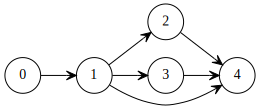

In [20]:
graph.Visualize()

# Базовые обходы

## Обход в глубину (Depth first search, dfs)
Суть обхода в глубину заключается в следующей задаче: в связном неориентированном графе найти такой цикл (возможно с повторением вершин), который проходит через все вершины. При условии отсутствия повторений эта задача становится гораздо более сложной (поиск гамильтонова цикла), но без этого ограничения оказывается, что решить довольно просто с помощью рекурсивной логики. Допустим мы хотим реализовать функцию $dfs(v)$ строит нам такой цикл, начиная с вершины $v$. Тогда рекуррентное правило для такой функции можно выразить как-то так: если $u_1, \ldots, u_k$ -- соседи $v$, то $dfs(v)=v, dfs(u_1), v, dfs(u_2), v, \ldots, v, dfs(u_k), v$. Иначе говоря, мы просто обходим по очереди каждого соседа, добавляя к получившемуся циклу переходы $v\rightarrow u_i$ вначале и $u_i\rightarrow v$ вконце. Если никак не ограничить возможность переходов, то описанное выше правило создает бесконечную рекурсию. Обычно это решается довольно простым способом: прерывать повторные вызовы $dfs(v)$ для одних и тех же вершин. В итоге алгоритм выглядит следующим образом (все функции выше $dfs$ используются только для визуализации).

In [21]:
def enter_node(node):
    node.SetColor('blue')
    
def enter_arc(node, arc):
    node.SetColor('green')
    arc.attributes['style'] = 'dashed'
    arc.attributes['color'] = 'green'
    
def return_from_arc(node, arc):
    arc.attributes['style'] = 'solid'
    arc.attributes['color'] = 'red'
    node.SetColor('blue')
    
def ignore_arc(arc):
    arc.attributes['color'] = 'blue'
    
def leave_node(node):
    node.SetColor('red')
    
def dfs(graph, node_id, visited, outlist, path):
    visited.add(node_id)
    path.append(node_id)
    enter_node(graph.nodes[node_id])
    outlist.append(graph.Visualize())
    for arc in graph.nodes[node_id].arcs:
        if arc.end not in visited:
            enter_arc(graph.nodes[node_id], arc)
            dfs(graph, arc.end, visited, outlist, path) 
            return_from_arc(graph.nodes[node_id], arc)
            path.append(node_id)
        else:
            ignore_arc(arc)
        outlist.append(graph.Visualize())      
    leave_node(graph.nodes[node_id])

In [22]:
graph = Graph(arcs)
visited = set()
dfs_outlist = []
path = []
dfs_outlist.append(graph.Visualize())
dfs(graph, 0, visited, dfs_outlist, path)
dfs_outlist.append(graph.Visualize())
print(path)

[0, 1, 2, 4, 2, 1, 3, 1, 0]


In [23]:
def step_slice(lst, idx):
    return lst[idx]

def animate_list(lst):
    return interact(step_slice, lst=fixed(lst), idx=widgets.IntSlider(min=0, max=len(lst)-1, step=1, value=0));

In [24]:
animate_list(dfs_outlist);

interactive(children=(IntSlider(value=0, description='idx', max=12), Output()), _dom_classes=('widget-interact…

## Примеры
### Выделение компонент связности
Компонента связности в неориентированном графе -- это множество вершин, в котором каждая пара вершин соединена путем, и при этом нет пути из вершины из этого множества в вершину не из этого множества. $dfs$ (ровно как и $bfs$, описанный далее) обходит ровно одну компоненту связности, при этом в $visited$ запоминаются вершины, которые посетил наш обход. Если запустить $dfs$ с сохранением $visited$ из каждой вершины, то в результате можно получить разбиение графа на компоненты связности

In [25]:
graph = Graph([
    Arc(0, 1),
    Arc(1, 2),
    Arc(2, 1),
    Arc(3, 4),
    Arc(3, 5)
])
visited = set()
components_outlist = []
print("Components:")
for node_id in graph.nodes:
    if node_id in visited:
        continue
    path = []
    components_outlist.append(graph.Visualize())
    dfs(graph, node_id, visited, components_outlist, path)
    components_outlist.append(graph.Visualize())
    print(set(path))
animate_list(components_outlist);

Components:
{0, 1, 2}
{3, 4, 5}


interactive(children=(IntSlider(value=0, description='idx', max=14), Output()), _dom_classes=('widget-interact…

### Топологическая сортировка и поиск циклов
В ориентированном графе всегда выполняется одно из двух: 1) вершины графа могут быть пронумерованы так, что ребра идут из вершины с меньшим номером в вершину с большим номером; 2) В графе есть цикл. Довольно очевидно, что при выполнении 2) невозможно 1). Чуть менее очевидно, что если 2) не выполняется, то обязательно выполняется 1). Сортировка вершин согласно 1) обычно называется <i><b>топологической сортировкой</b></i>. В визуализации $dfs$ использовались три цвета: черный для вершин, которые еще не посетили; зеленый для вершин, в которые вошли, но еще не вышли; красный для вершин, из которых уже вышли. Оказывается, что если в графе есть цикл, в $dfs$ обязательно в какой-то момент мы будем обрабатывать ребро, ведущее в зеленую вершину. С помощью $dfs$ также довольно легко получить топологический порядок: если из $v$ есть переходы в $u_1, \ldots, u_k$, то нужно сначала обойти и пронумеровать все $u_i$, а потом уже пронумеровать $v$ номером, меньшим, чем пронумерованные ранее. Обычно это удобно делать задом наперед.

In [26]:
def top_sort(graph, node_id, visited, stack, reversed_top_order):
    visited[node_id] = 'green'
    stack.append(node_id)
    for arc in graph.nodes[node_id].arcs:
        if arc.end in visited:
            if visited[arc.end] == 'green':
                for i, v in enumerate(stack):
                    if v == arc.end:
                        return stack[i:]
        else:
            result = top_sort(graph, arc.end, visited, stack, reversed_top_order)
            if result is not None:
                return result
    reversed_top_order.append(node_id)
    stack = stack[:-1]
    visited[node_id] = 'blue'
    return None

def try_top_sort(graph):
    visited = dict()
    stack = []
    reversed_top_order = []
    for node_id in graph.nodes:
        if node_id in visited:
            continue
        has_cycle = top_sort(graph, node_id, visited, stack, reversed_top_order)
        if has_cycle is not None:
            print ("Cycle detecetd:", has_cycle)
            return
    print("No cycles, proper ordering:", list(reversed(reversed_top_order)))

No cycles, proper ordering: [7, 8, 3, 0, 5, 6, 1, 2]


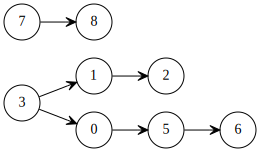

In [27]:
graph = Graph([
    Arc(3, 1),
    Arc(1, 2), 
    Arc(3, 0),
    Arc(0, 5),
    Arc(5, 6),
    Arc(7, 8)
])
try_top_sort(graph)
graph.Visualize()

Cycle detecetd: [3, 1, 2, 6]


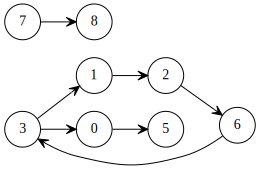

In [28]:
graph = Graph([
    Arc(3, 1),
    Arc(1, 2), 
    Arc(3, 0),
    Arc(0, 5),
    Arc(6, 3),
    Arc(7, 8),
    Arc(2, 6)
])
try_top_sort(graph)
graph.Visualize()

Топологическая сортировка графа, если она возможна, помогает во многих друих задачах, например нахождении кратчайших расстояний в графе. Вычислительные графы, использующиеся в pytorch, tensorflow и т.п., также ацикличны, топологическая сортировка для них выдает порядок, в котором должны быть произведены вычисления. Мы также сталкивались с довольно интересной ситуацией: в конфигурационных файлах вычислительных графов для нейронных сетей в калди могут быть циклы из-за особенностей реализации реккурентных связей. Для дого, чтобы проанализировать граф из калди и перевести его в другой формат (cntk) необходимо было выделить <i><b>компоненты сильной связности</b></i>, для чего обычно используется более хитрый [алгоритм Тарьяна](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%A2%D0%B0%D1%80%D1%8C%D1%8F%D0%BD%D0%B0), основанный на идеях, использующихся в топологической сортировке.

In [29]:
import os

def import_as_beamer_images(outlist, imagedir, preffix, frame_name=""):
    latex_lines = []
    if not os.path.isdir(imagedir):
        os.makedirs(imagedir)
    for i, graph_repr in enumerate(outlist):
        latex_lines.append(f'\\begin{{frame}}{{frame_name}}')
        graph_repr.render(filename=os.path.join(imagedir, preffix + str(i)),
                        format='pdf')
        latex_lines.append(f'\t\\includegraphics[width=\textwidth]{imagedir}/{preffix}{str(i)}.pdf')
        latex_lines.append(f'\\end{{frame}}')
    return latex_lines

In [37]:
latex_lines = import_as_beamer_images(dfs_outlist, 
                        '/mnt/k11/home/malkovskiy/work/decoder_2019/decoder_prototype/notebooks/graph_images/dfs',
                        'dfs')

In [38]:
with open('/mnt/k11/home/malkovskiy/work/decoder_2019/decoder_prototype/notebooks/graph_images/dfs/frames.tex', 'w') as f:
    print('\n'.join(latex_lines), file=f)

## Обход в ширину (breadth first search, bfs)
Основная 

In [32]:
import queue

In [33]:
def process_arc(arc):
    arc.attributes['color'] = 'blue'

def put_node_in_queue(node):
    node.SetColor('green')
    
def process_node(node):
    node.SetColor('blue')

def bfs(graph, s, outlist):
    dist = dict()
    q = queue.Queue()
    q.put(s)
    dist[s] = 0
    while not q.empty():
        cur = q.get()
        v = graph.nodes[cur]
        d = dist[cur]
        process_node(v)
        outlist.append(graph.Visualize())
        for arc in v.arcs:
            process_arc(arc)
            if arc.end not in dist:
                put_node_in_queue(graph.nodes[arc.end])
                dist[arc.end] = d + 1
                q.put(arc.end)
        outlist.append(graph.Visualize())       
    return dist          

In [36]:
graph = Graph(arcs)
outlist = []
outlist.append(graph.Visualize())
dist = bfs(graph, 0, outlist)
print(dist)
animate_list(outlist);

{0: 0, 1: 1, 2: 2, 3: 2, 4: 2}


interactive(children=(IntSlider(value=0, description='idx', max=10), Output()), _dom_classes=('widget-interact…

## Примеры